In [3]:
#Importing essential libraries 
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt

In [6]:
#Set the random seed
np.random.seed(42)

#Create a quantum device
device = qml.device('default.qubit', wires = 3)

@qml.qnode(device, diff_method = 'parameter-shift')
def circuit(params):
  qml.RX(params[0], wires = 0)
  qml.RY(params[1], wires = 1)
  qml.RZ(params[2], wires = 2)

  qml.broadcast(qml.CNOT, wires = [0, 1, 2], pattern = 'ring')

  qml.RX(params[3], wires = 0)
  qml.RY(params[4], wires = 1)
  qml.RZ(params[5], wires = 2)

  qml.broadcast(qml.CNOT, wires = [0, 1, 2], pattern = "ring")
  return qml.expval(qml.PauliY(0) @ qml.PauliZ(2))

In [9]:
#Initial parameters
params = np.random.random([6], requires_grad = True)

print("Parameters:", params)
print("Expectation value", circuit(params))

Parameters: [0.05808361 0.86617615 0.60111501 0.70807258 0.02058449 0.96990985]
Expectation value -0.014055527571701504


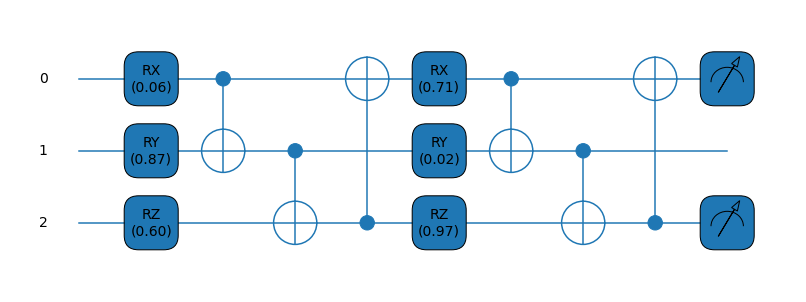

In [10]:
fig, ax = qml.draw_mpl(circuit, decimals = 2)(params)
plt.show()

In [11]:
def parameter_shift_term(qnode, params, i):
  shifted = params.copy()
  shifted[i] += np.pi/2
  forward = qnode(shifted) #forward evaluation

  shifted[i] -= np.pi
  backward = qnode(shifted) #backward evaluation

  return 0.5 * (forward - backward)

In [12]:
#gradient with respect to the first parameter
print(parameter_shift_term(circuit, params, 0))

-0.011114621351495317


In [14]:
def parameter_shift(qnode, params):
  gradient = np.zeros([len(params)])

  for i in range(len(params)):
    gradient[i] = parameter_shift_term(qnode, params, i)
  
  return gradient

In [15]:
print(parameter_shift(circuit, params))

[-1.11146214e-02 -5.87918653e-04  0.00000000e+00 -1.50168133e-02
 -6.82724681e-01  0.00000000e+00]


In [16]:
grad_function = qml.grad(circuit)
print(grad_function(params)[0])

-0.011114621351495317


In [17]:
print(qml.gradients.param_shift(circuit)(params))

[[-1.11146214e-02 -5.87918653e-04 -5.55111512e-17 -1.50168133e-02
  -6.82724681e-01  2.77555756e-17]]


In [18]:
dev = qml.device("default.qubit", wires = 4)

@qml.qnode(dev, diff_method = "parameter-shift")
def circuit(params):
  qml.StronglyEntanglingLayers(params , wires = [0, 1, 2, 3])
  return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

#initialize circuit parameters
param_shape = qml.StronglyEntanglingLayers.shape(n_wires = 4, n_layers = 15)
params = np.random.normal(scale = 0.1, size = param_shape, requires_grad = True)
print(params.size)
print(circuit(params))

180
0.9195547012778199


In [20]:
import timeit

reps = 3
num = 10

times = timeit.repeat("circuit(params)", globals = globals(), number = num, repeat = reps)
forward_time = min(times)/num

print(f"Forward pass (best of {reps}) : {forward_time} sec per loop")

Forward pass (best of 3) : 0.023837742000023355 sec per loop


In [21]:
#create the gradient function
grad_fn = qml.grad(circuit)

times = timeit.repeat("grad_fn(params)", globals = globals(), number = num, repeat = reps)
backward_time = min(times)/num

print(f"Gradient Computation (best of {reps}) : {backward_time} secs per loop")

Gradient Computation (best of 3) : 6.912203136400012 secs per loop
